<a href="https://colab.research.google.com/github/Kosher-T/Colab_Projects/blob/main/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import copy
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [2]:
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp(C)', 'radiation', 'rain', 'snow', 'functional']
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis=1)

In [3]:
df.columns = dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df[df['hour'] == 12]
df.drop('hour', axis=1, inplace=True)

In [4]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp(C),radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


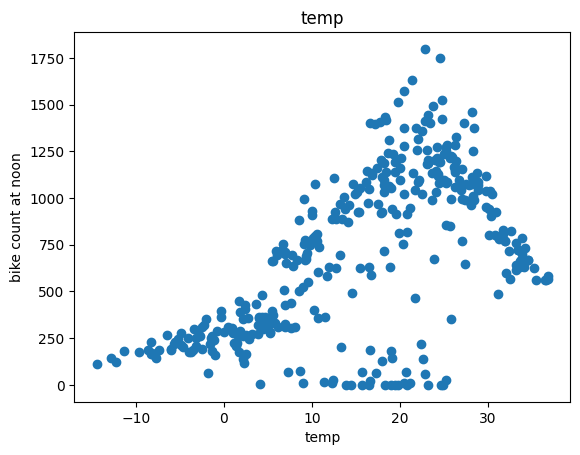

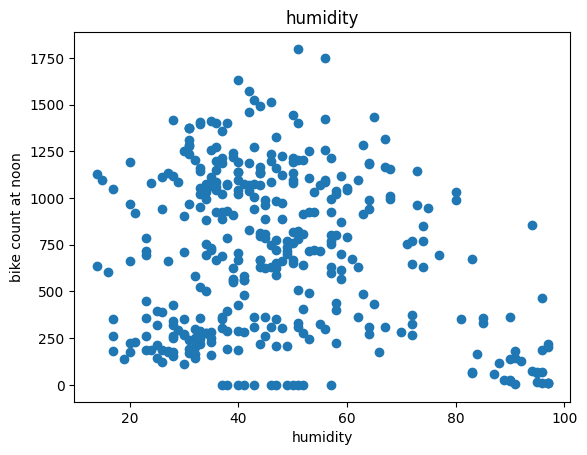

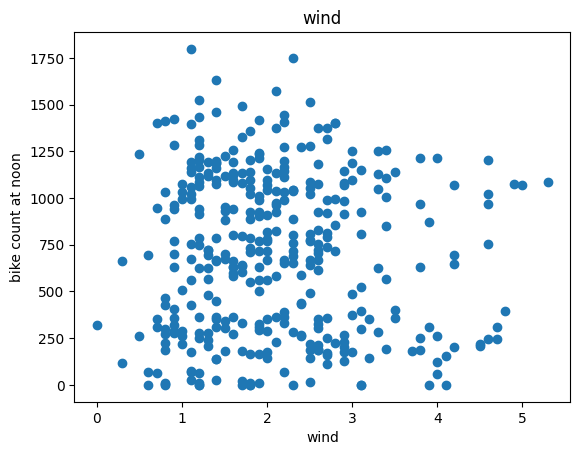

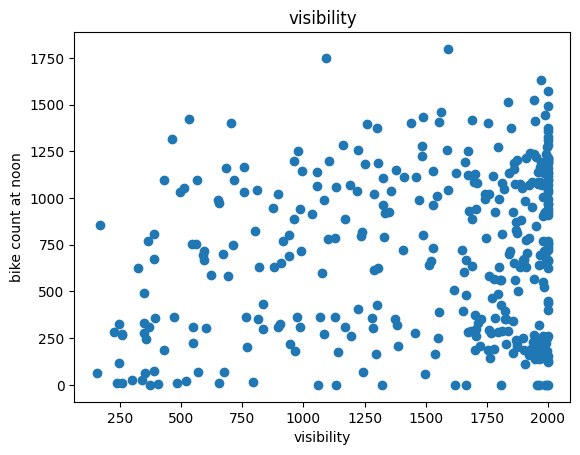

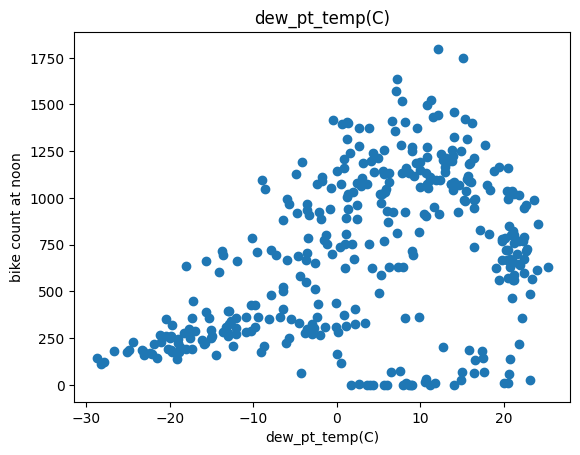

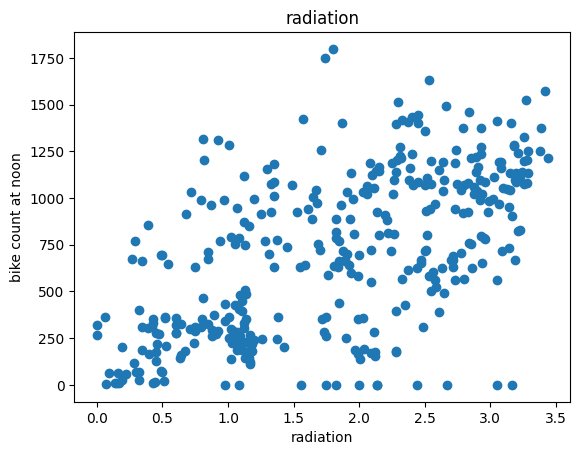

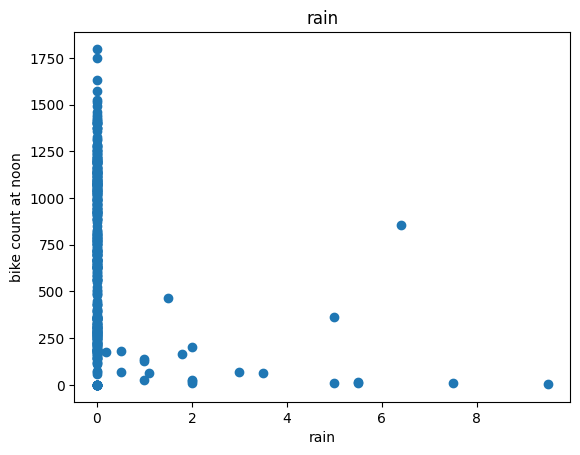

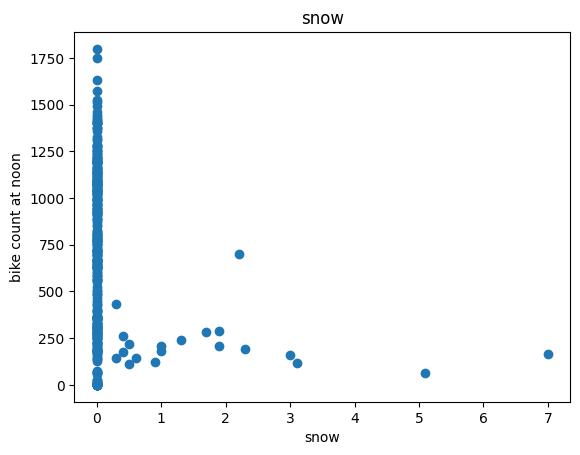

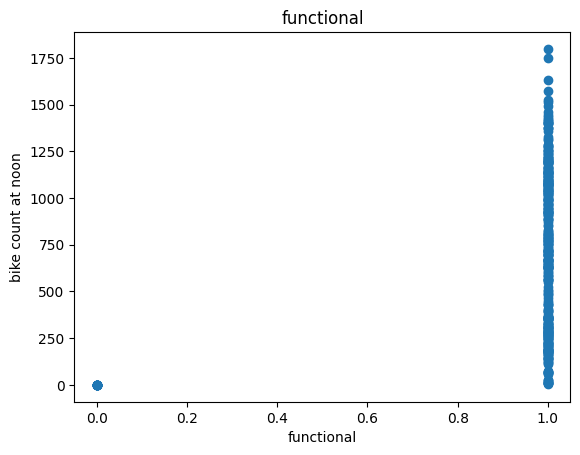

In [5]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('bike count at noon')
    plt.show()

In [6]:
# We'll drop some of the columns that don't seem to matter, that aren't linear: wind, visinility and functional
df.drop(['wind', 'visibility', 'functional'], axis=1, inplace=True)
df.head()

,bike_count,temp,humidity,dew_pt_temp(C),radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Now, splitting the dataset into training/valid/test

In [7]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [15]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    elif len(x_labels) == 1:
        X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
        X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [9]:
_train_temp, x_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_valid_temp, x_valid_temp, y_valid_temp = get_xy(valid, 'bike_count', x_labels=['temp'])
_test_temp, x_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [10]:
temp_reg = LinearRegression().fit(x_train_temp, y_train_temp)

In [11]:
temp_reg.score(x_train_temp, y_train_temp)

0.37932347948732714

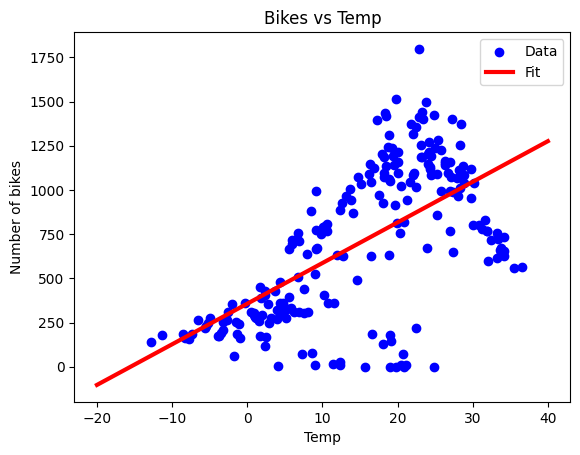

In [12]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [13]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp(C)', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [18]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
all_reg =LinearRegression().fit(X_train_all, y_train_all)

In [20]:
all_reg.score(X_train_all, y_train_all)

0.4552493511229052

# Regression with neural net

In [30]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [32]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [33]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_valid_temp, y_valid_temp)
)

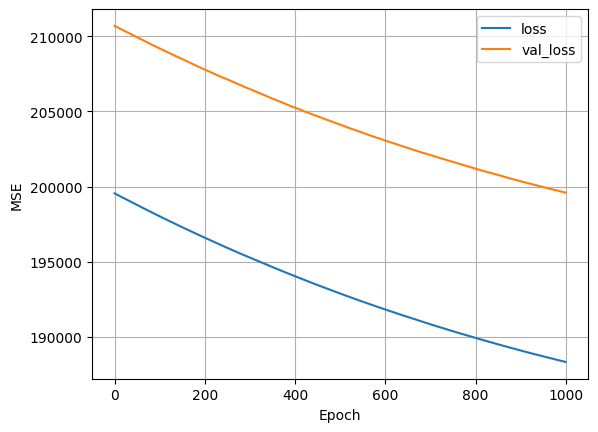

In [34]:
plot_loss(history)